In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats #aykırı değerlerin testbiti ve baskılanması 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder #kategorik değişkenleri nümerik hale getirme
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM , Dropout
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
import tensorflow as tf

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        import warnings
warnings.filterwarnings("ignore")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/toyota-motors-stock-data-2980-2024/Toyota_Data.csv


In [2]:
df = pd.read_csv("/kaggle/input/toyota-motors-stock-data-2980-2024/Toyota_Data.csv")

# VERİYE GENEL BAKIŞ

In [3]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109
1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343
2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0
3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277
4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409


In [4]:
df.columns = df.columns.str.strip()

In [5]:
numeric_cols =df.select_dtypes(include=['float64','int64'])

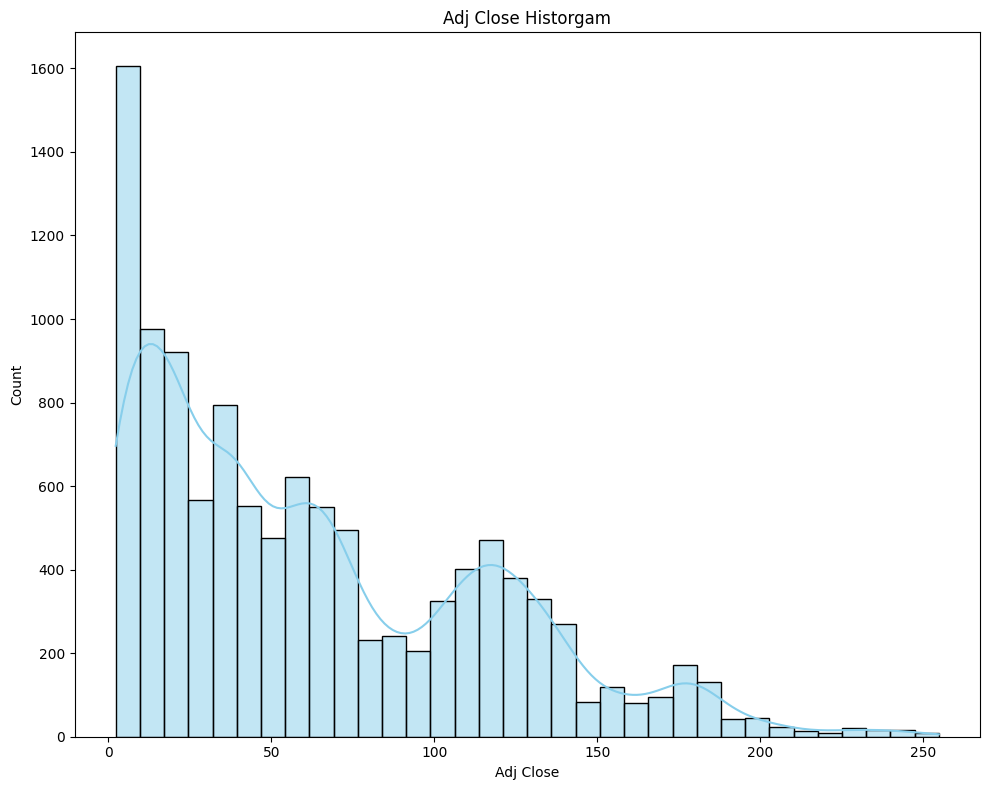

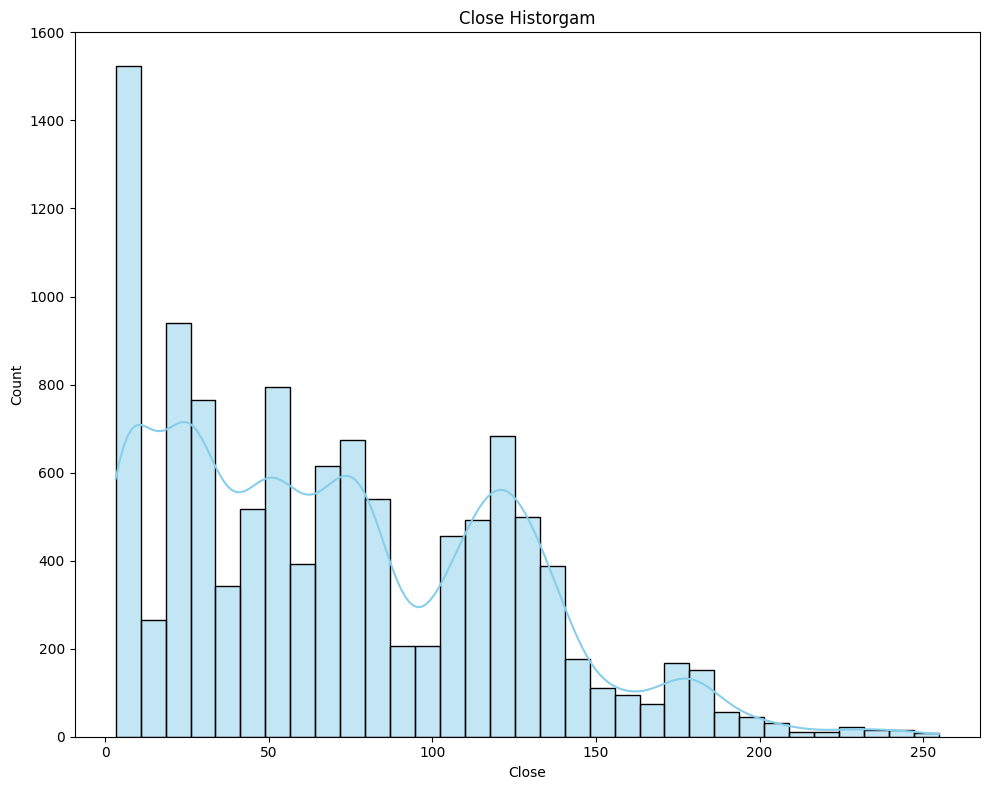

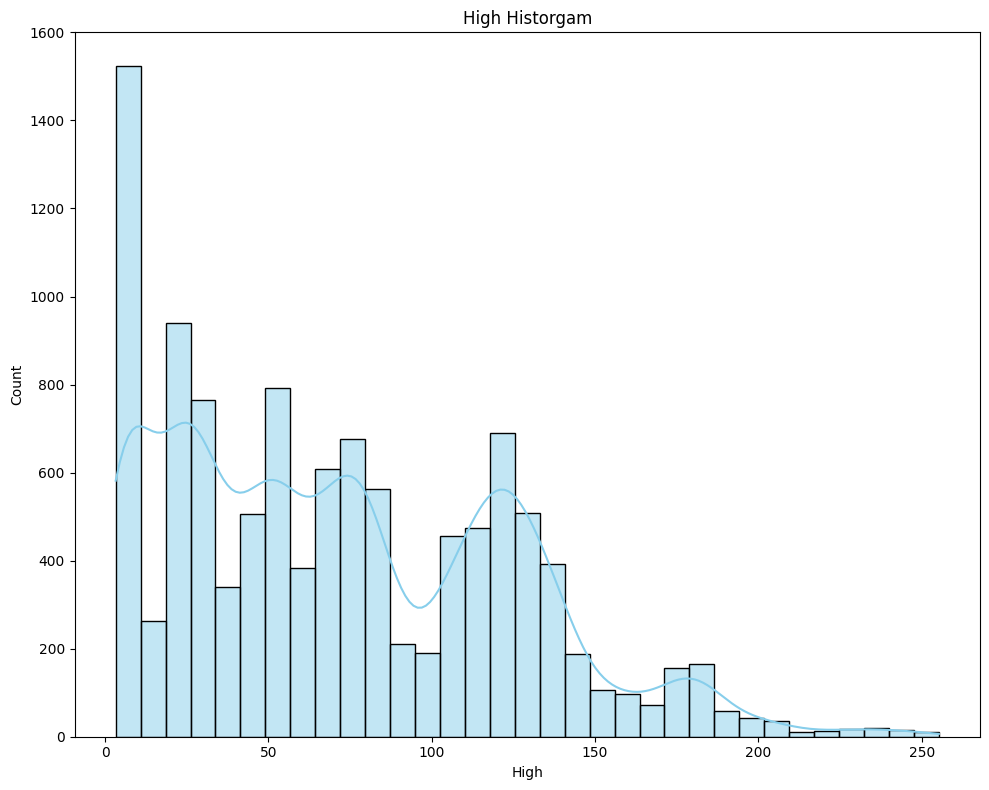

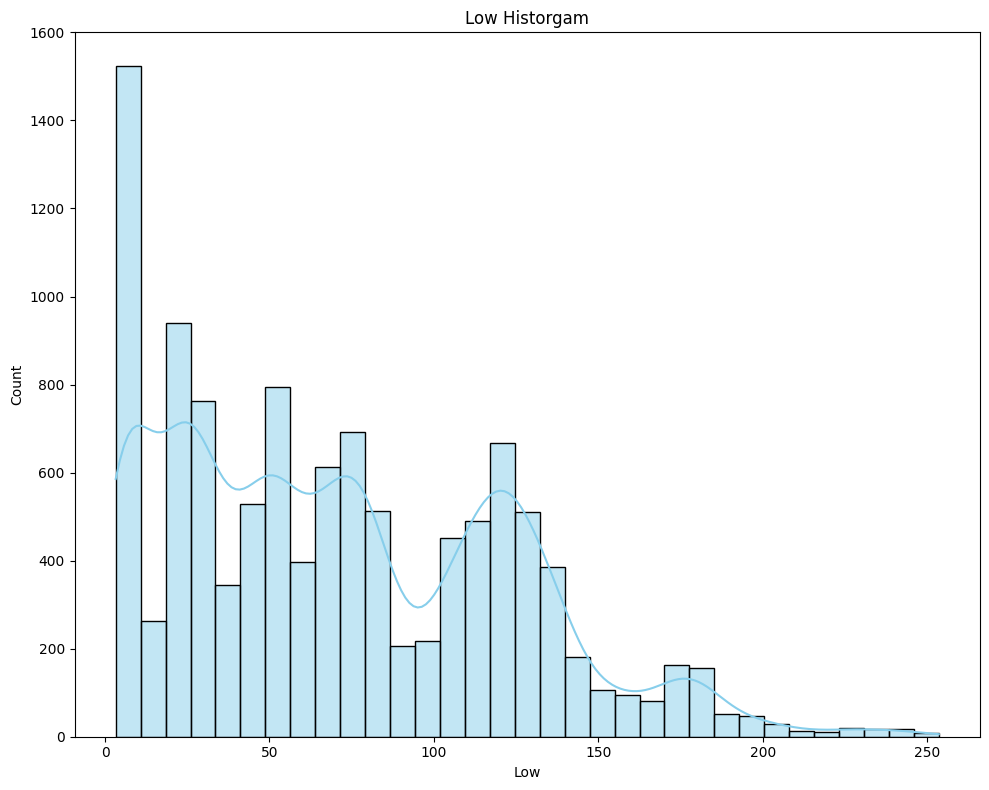

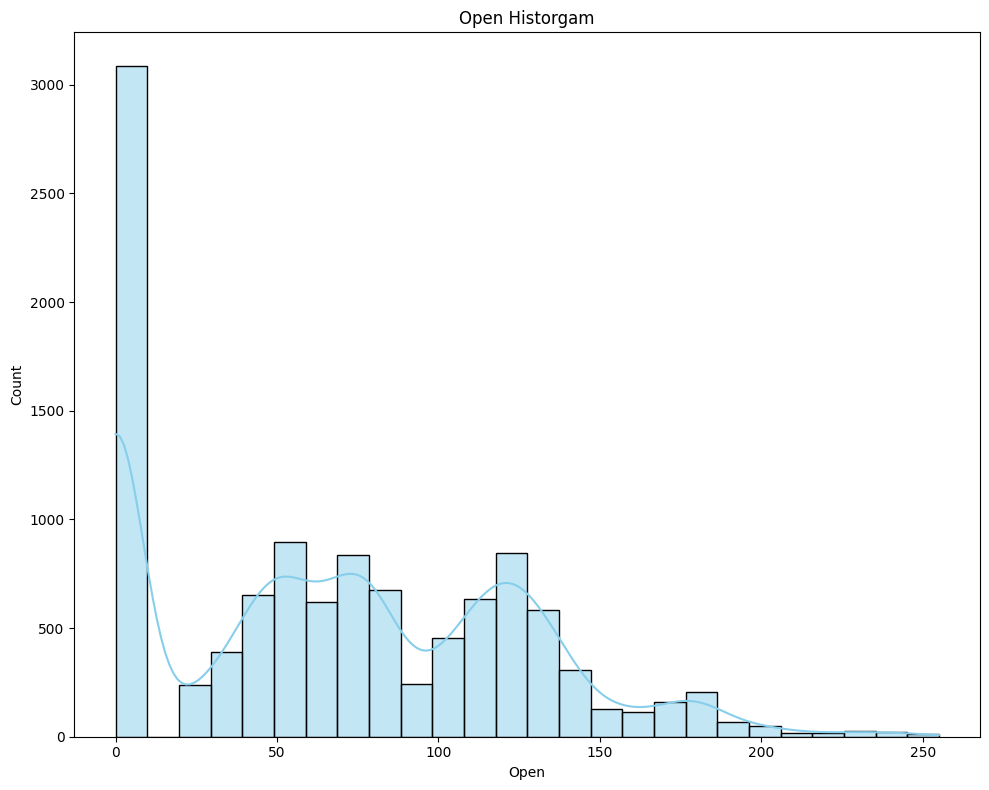

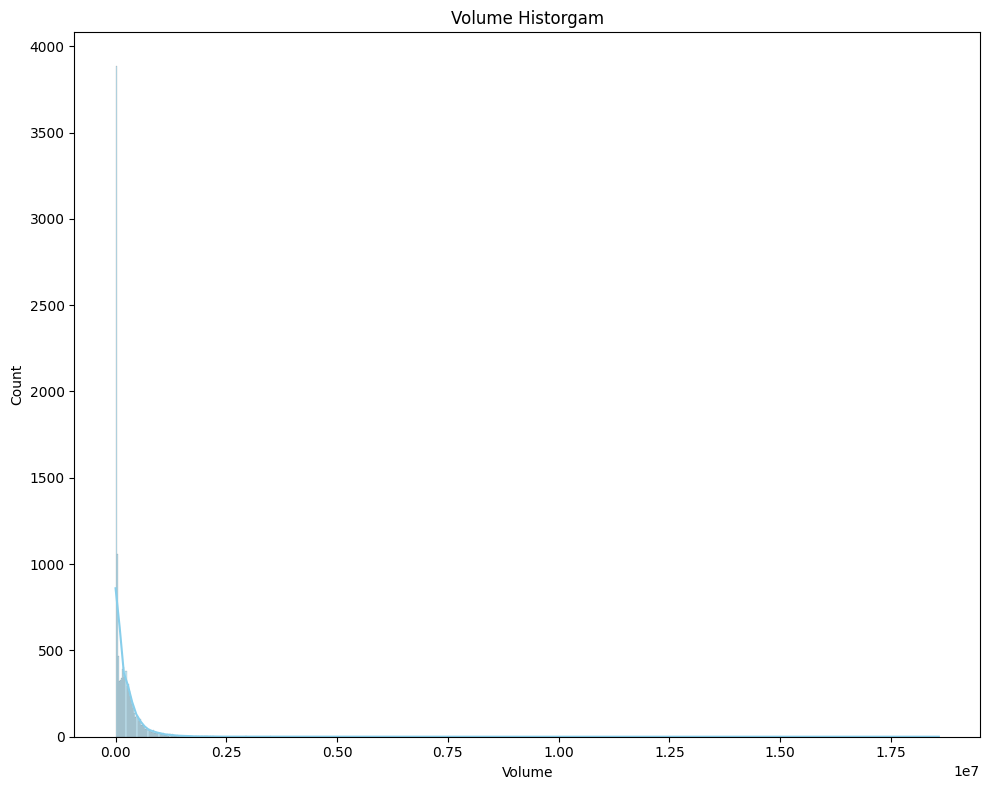

In [6]:
 for col in numeric_cols:
        plt.figure(figsize=(10,8))
        sns.histplot(data=df,x=col,kde='True',color='skyblue')
        plt.title(f"{col} Historgam")
        plt.tight_layout()
        plt.show()

In [7]:
numeric_cols.head(5)

,Adj Close,Close,High,Low,Open,Volume
0,2.296798,3.291227,3.344743,3.291227,0.000000,41109
1,2.306134,3.304606,3.358122,3.304606,0.000000,9343
2,2.306134,3.304606,3.304606,3.304606,3.304606,0
3,2.306134,3.304606,3.358122,3.304606,0.000000,10277
4,2.362154,3.384880,3.438396,3.384880,0.000000,8409


**Histogram grafiklerimiz genel itibari ile inişli çıkışlı bir dağılım göstermiş normallikleri hakkında net bir şey söyleyememekle beraber  bu iniş ve  çıkışların daha yakından analiz edilip sebep ve sonuç ilşkisi ortaya atılabilir.**

**Gün içerisinde işlem gören toplam hisse senedi sayısının diğer değişkenlere olan ilişkisi**

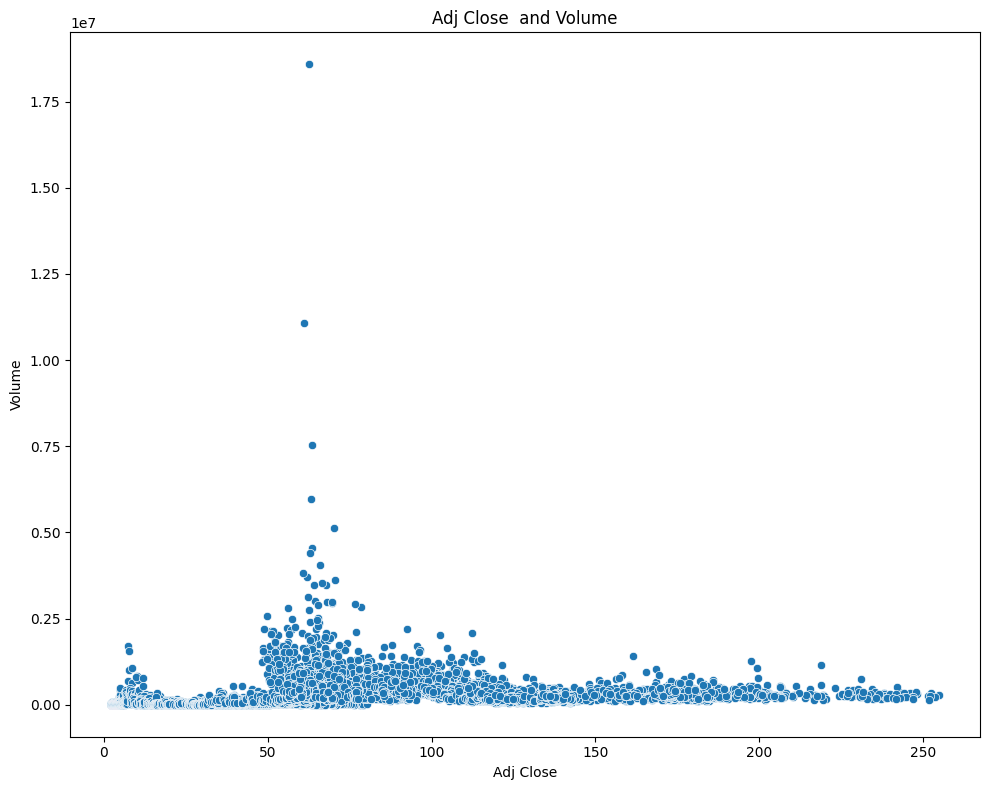

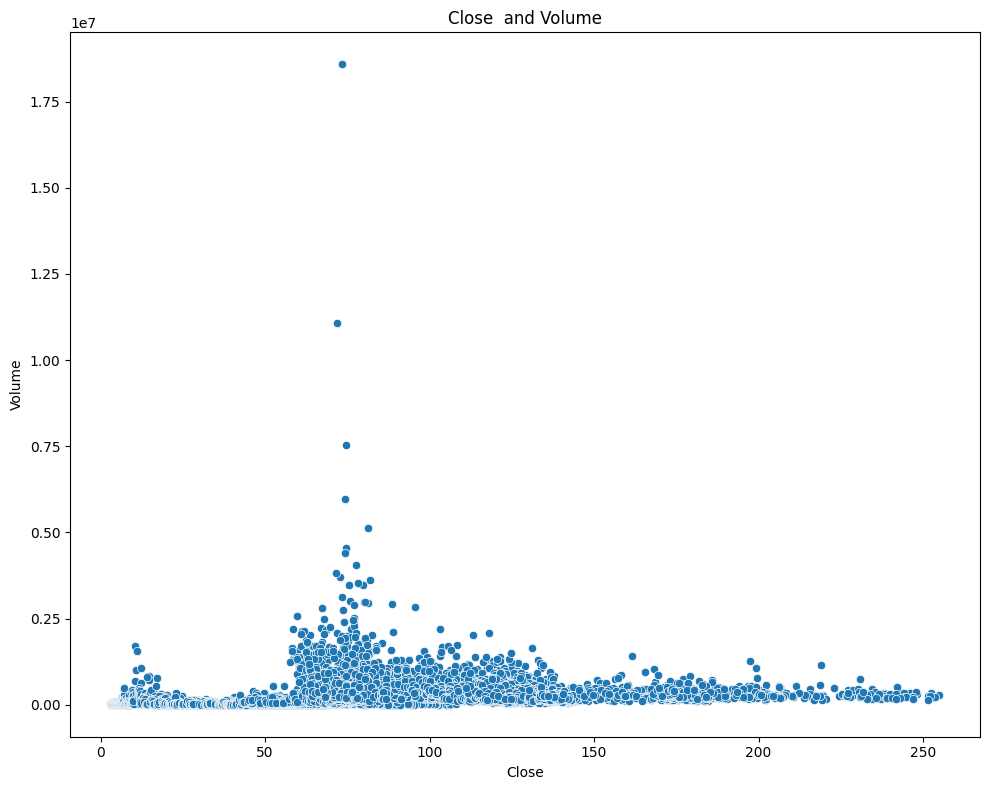

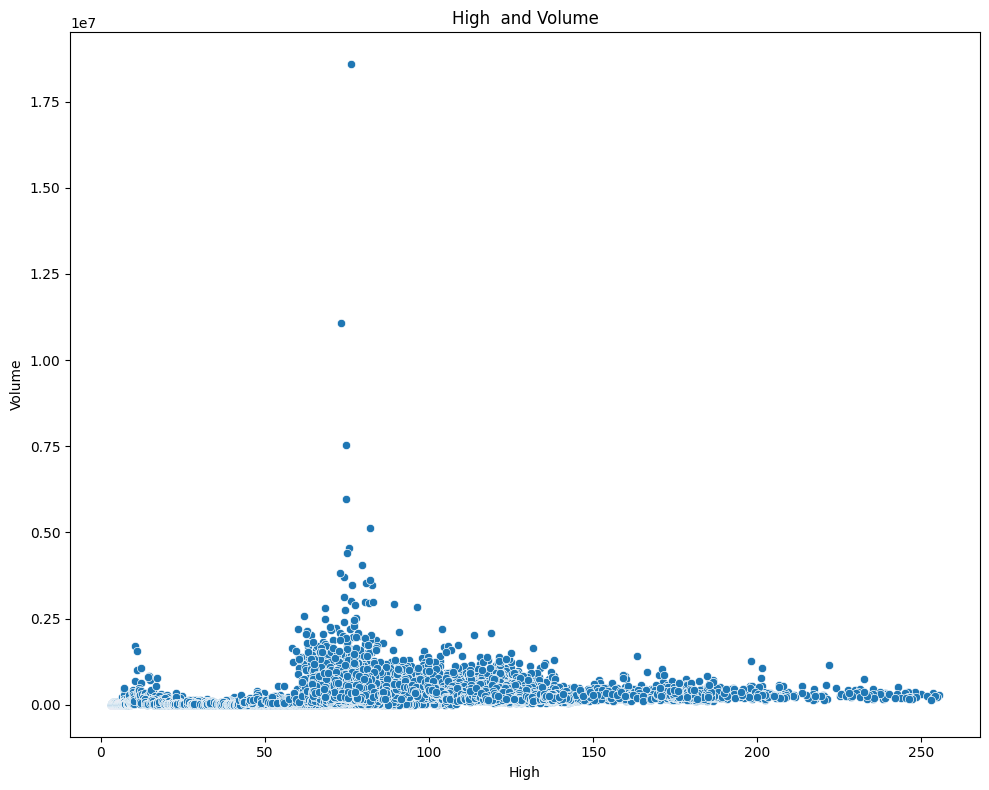

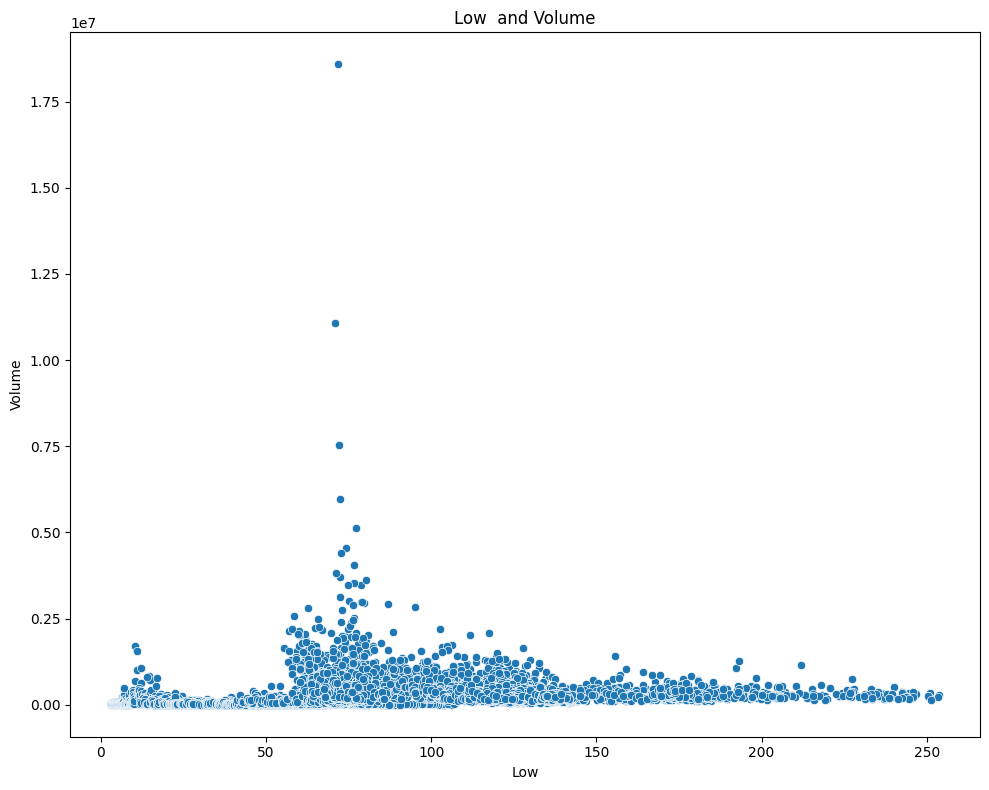

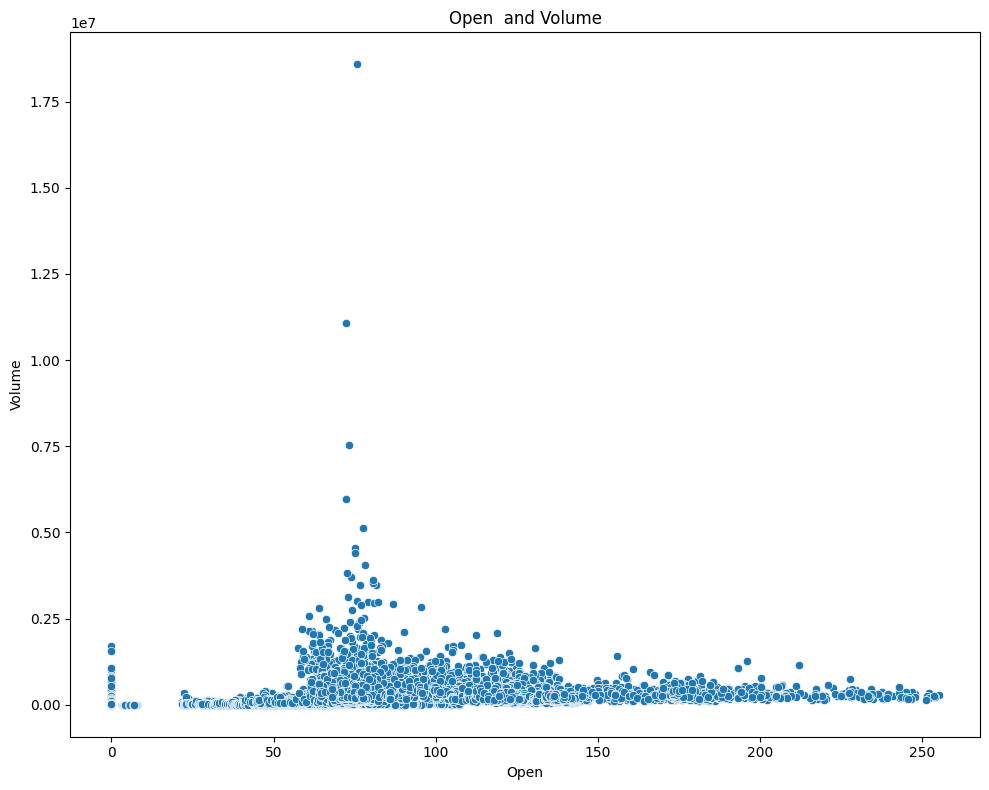

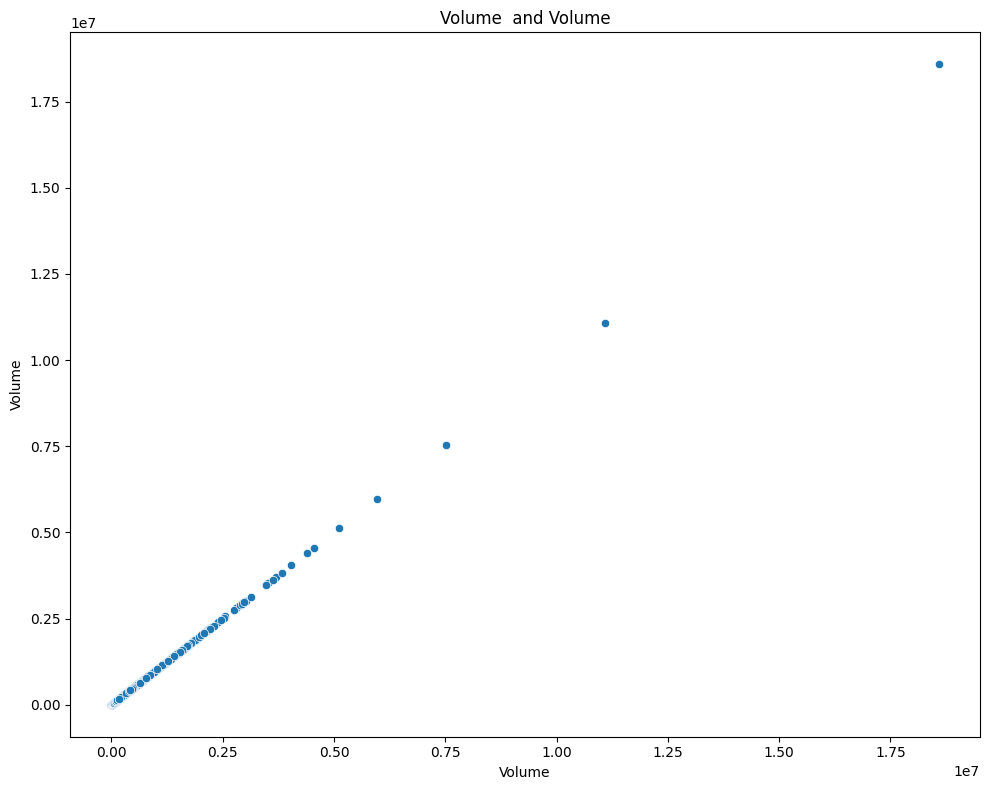

In [8]:
for col in numeric_cols:
    plt.figure(figsize=(10,8))
    sns.scatterplot(data=df,x=col,y='Volume',palette='virdis')
    plt.title(f"{col}  and Volume")
    plt.xlabel(col)
    plt.ylabel("Volume")
    plt.tight_layout()
    plt.show()

# VERİ ÖN İŞLEME

In [9]:
def dataset(dataframe,head=True):
    print("------------------------------------SHAPE--------------------------------------------")
    print(dataframe.shape)
    print("------------------------------------İNFO----------------------------------------------")
    print(dataframe.info())
    print("------------------------------------İSNULL--------------------------------------------")
    print(dataframe.isnull().sum().sort_values(ascending=False))
    print("------------------------------------NUNİQUE-------------------------------------------")
    print(dataframe.nunique())
    print("-----------------------------------DESCRİBE-------------------------------------------")
    display(dataframe.describe())
    if head:
        print("-------------------------------HEAD-----------------------------------------------")
        display(dataframe.head())
        print("-------------------------------TAIL-----------------------------------------------")
        display(dataframe.tail())

In [10]:
dataset(df,head=True)

------------------------------------SHAPE--------------------------------------------
(11291, 7)
------------------------------------İNFO----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       11291 non-null  object 
 1   Adj Close  11291 non-null  float64
 2   Close      11291 non-null  float64
 3   High       11291 non-null  float64
 4   Low        11291 non-null  float64
 5   Open       11291 non-null  float64
 6   Volume     11291 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 617.6+ KB
None
------------------------------------İSNULL--------------------------------------------
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64
------------------------------------NUNİQUE-------------------------------

,Adj Close,Close,High,Low,Open,Volume
count,11291.000000,11291.000000,11291.000000,11291.000000,11291.000000,1.129100e+04
mean,63.586275,72.057776,72.478879,71.646418,67.955424,2.146604e+05
std,52.272225,51.295776,51.552662,50.976716,55.851523,3.874256e+05
min,2.259452,3.237711,3.237711,3.237711,0.000000,0.000000e+00
25%,19.224636,27.548208,27.735613,27.548208,0.000000,1.350000e+04
50%,50.583900,66.040001,66.650002,65.440002,66.000000,9.100000e+04
75%,104.705669,114.295002,114.895000,113.625000,114.294998,2.923000e+05
max,254.770004,254.770004,255.229996,253.589996,255.000000,1.858270e+07


-------------------------------HEAD-----------------------------------------------


,Date,Adj Close,Close,High,Low,Open,Volume
0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109
1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343
2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0
3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277
4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409


-------------------------------TAIL-----------------------------------------------


,Date,Adj Close,Close,High,Low,Open,Volume
11286,2024-12-20,178.169998,178.169998,179.919998,175.839996,175.839996,425700
11287,2024-12-23,180.449997,180.449997,180.619995,177.970001,179.119995,422700
11288,2024-12-24,181.429993,181.429993,181.720001,180.830002,181.000000,168600
11289,2024-12-26,197.360001,197.360001,198.000000,193.130005,195.970001,1281200
11290,2024-12-27,199.520004,199.520004,201.000000,198.179993,200.360001,779500


**Date kolonunun veri tipini object den date ye çevirmemiz gerekiyor.**

In [11]:
df['Date'] =pd.to_datetime(df['Date'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       11291 non-null  datetime64[ns]
 1   Adj Close  11291 non-null  float64       
 2   Close      11291 non-null  float64       
 3   High       11291 non-null  float64       
 4   Low        11291 non-null  float64       
 5   Open       11291 non-null  float64       
 6   Volume     11291 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 617.6 KB


In [13]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109
1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343
2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0
3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277
4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409


**numeric_cols** :Adj Close	Close	High	Low	Open	Volume

**datetime**  : Date

**Nümerik Değişkenlerin Birbirileri  Arasındaki Korelasyonları**

In [14]:
numeric_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

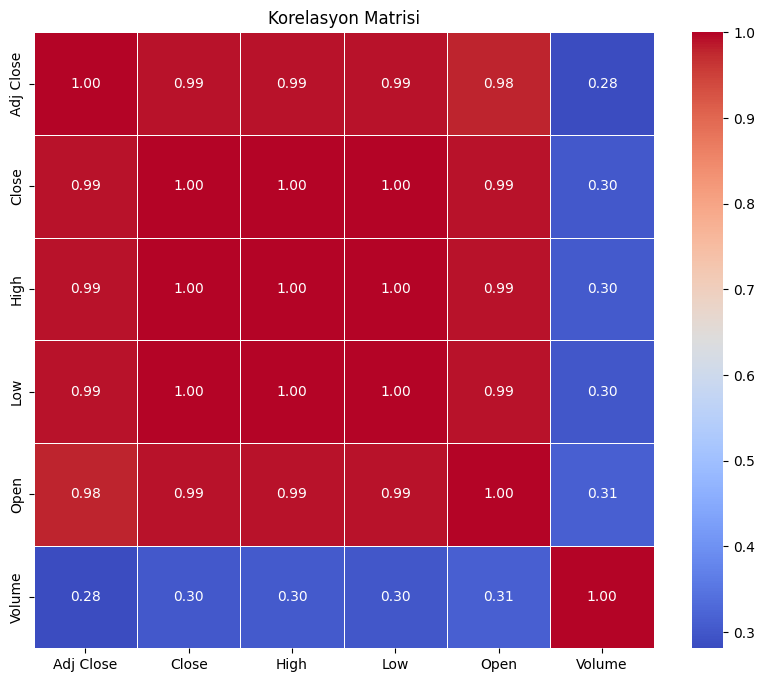

In [15]:
correlation_matrix=df[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(data=correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm',linewidths=0.5)
plt.title("Korelasyon Matrisi")
plt.show()

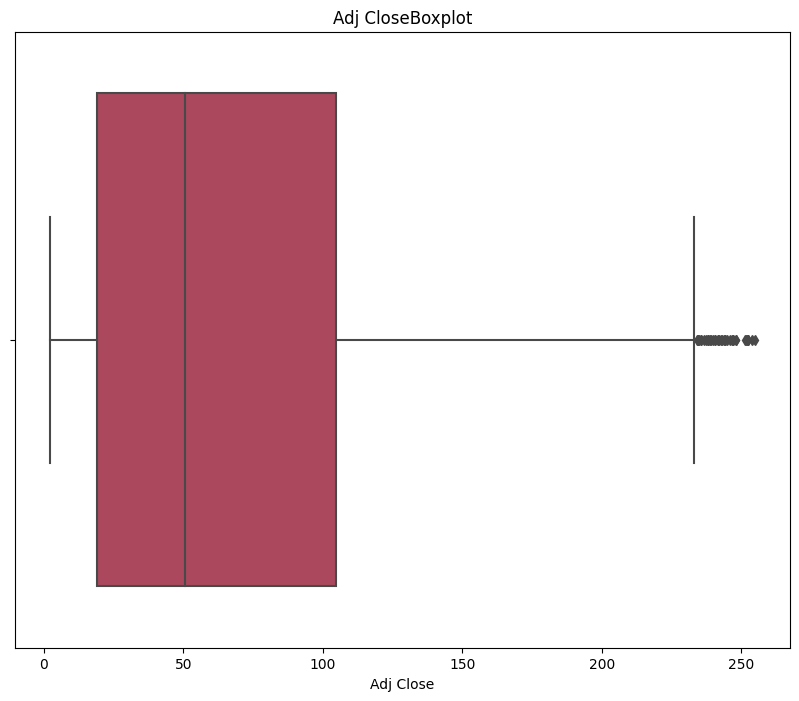

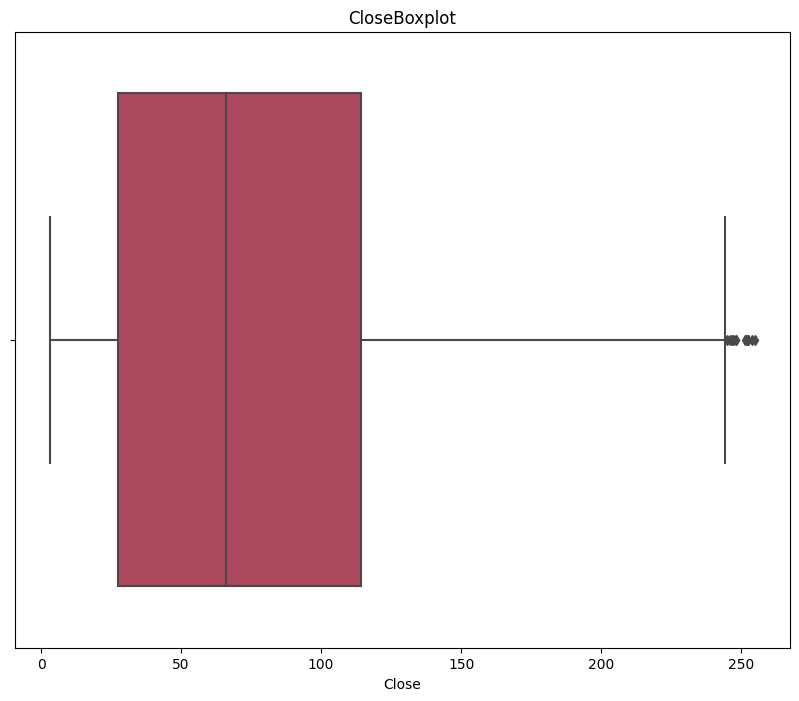

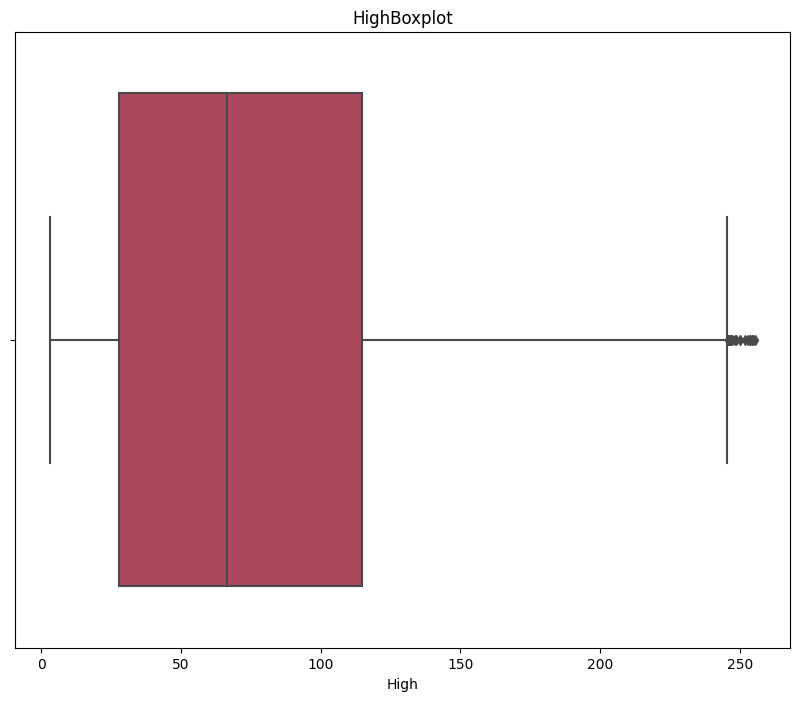

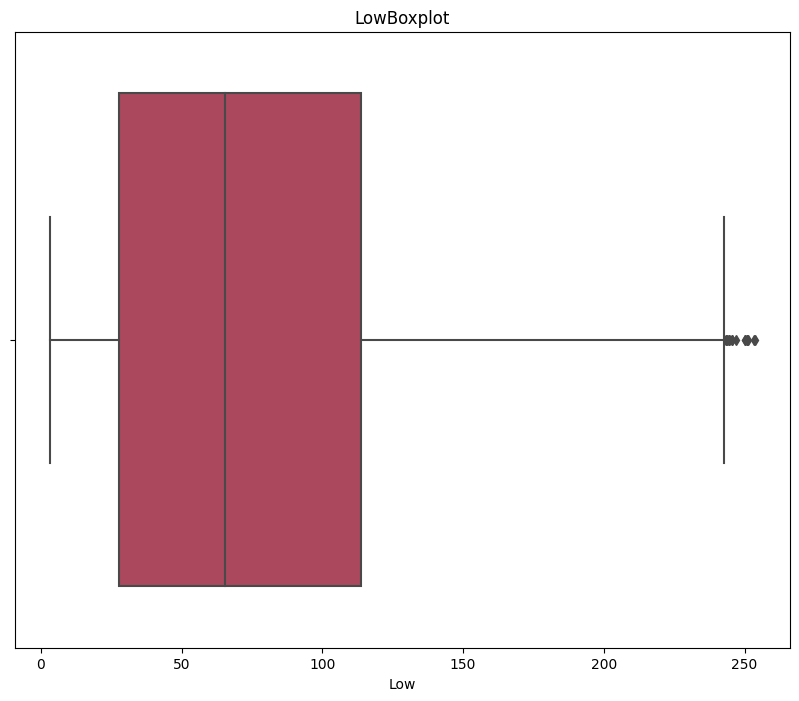

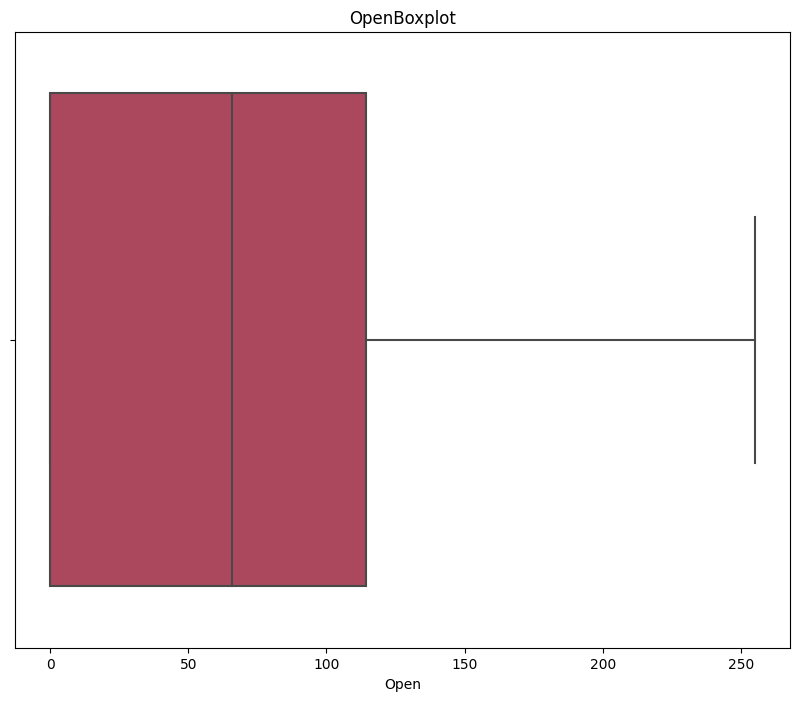

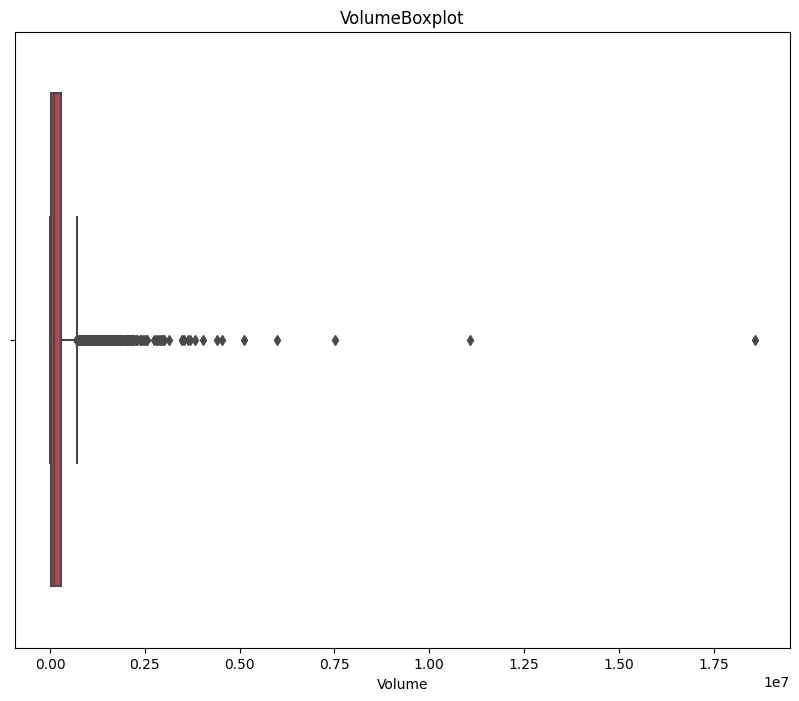

In [16]:
for col in numeric_cols:
    plt.figure(figsize=(10,8))
    sns.boxplot(data=df,x=col,palette='inferno')
    plt.title(f"{col}Boxplot")
    plt.show()

**IQR İLE AYKIRI DEĞERLERLİN BASKILANMASI**

In [17]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)

In [18]:
outliers.sum()

0

# KEŞİFSEL VERİ ANALİZİ(EDA)

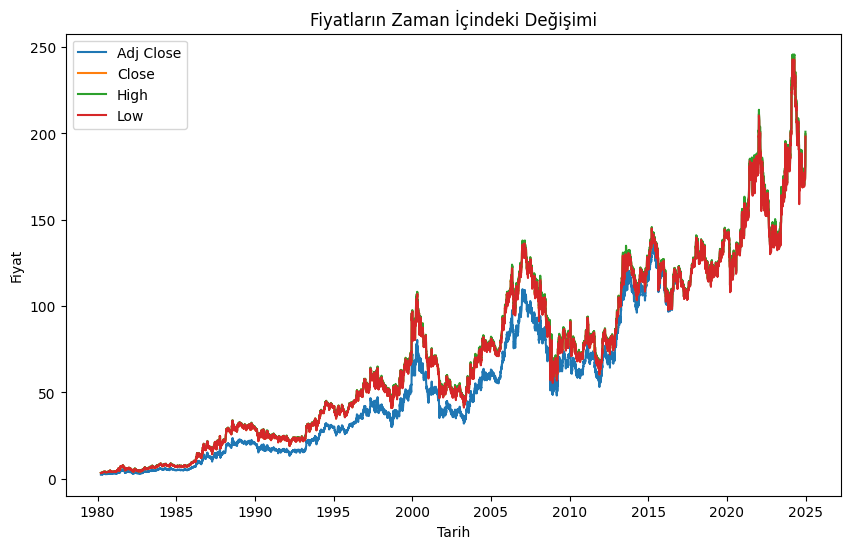

In [19]:
plt.figure(figsize=(10, 6))
for column in ['Adj Close', 'Close', 'High', 'Low']:
    plt.plot(df['Date'], df[column], label=column)
plt.title('Fiyatların Zaman İçindeki Değişimi')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()


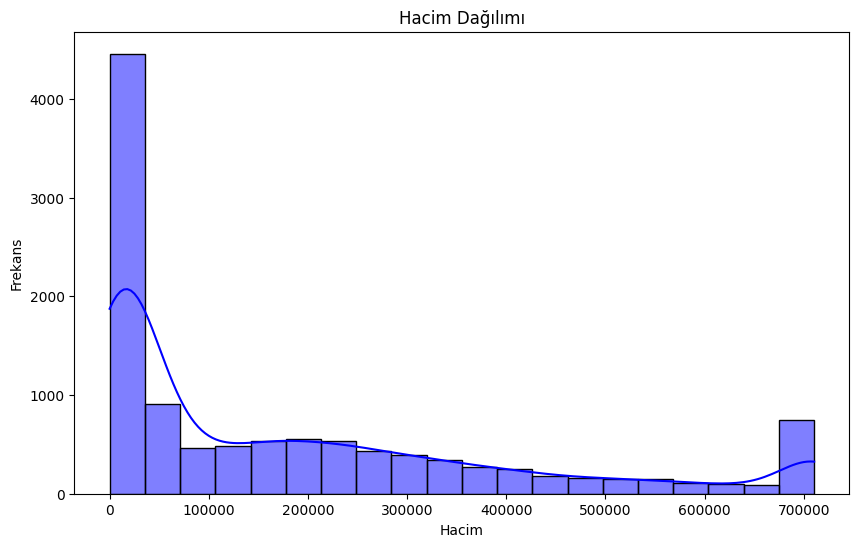

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Volume'], kde=True, color='blue', bins=20)
plt.title('Hacim Dağılımı')
plt.xlabel('Hacim')
plt.ylabel('Frekans')
plt.show()

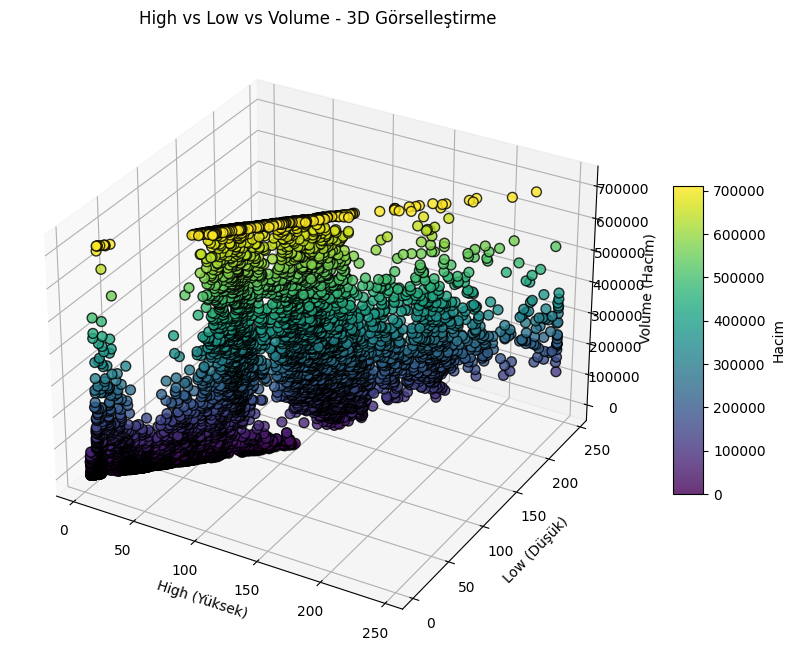

In [21]:
# 3D Dağılım Grafiği
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# X, Y, Z eksenleri
x = df['High']
y = df['Low']
z = df['Volume']

# 3D Scatter Plot
sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=50, alpha=0.8, edgecolor='k')

# Ekseni etiketleri
ax.set_xlabel('High (Yüksek)')
ax.set_ylabel('Low (Düşük)')
ax.set_zlabel('Volume (Hacim)')

# Renk barı ekleme
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Hacim')

# Başlık
plt.title('High vs Low vs Volume - 3D Görselleştirme')
plt.show()

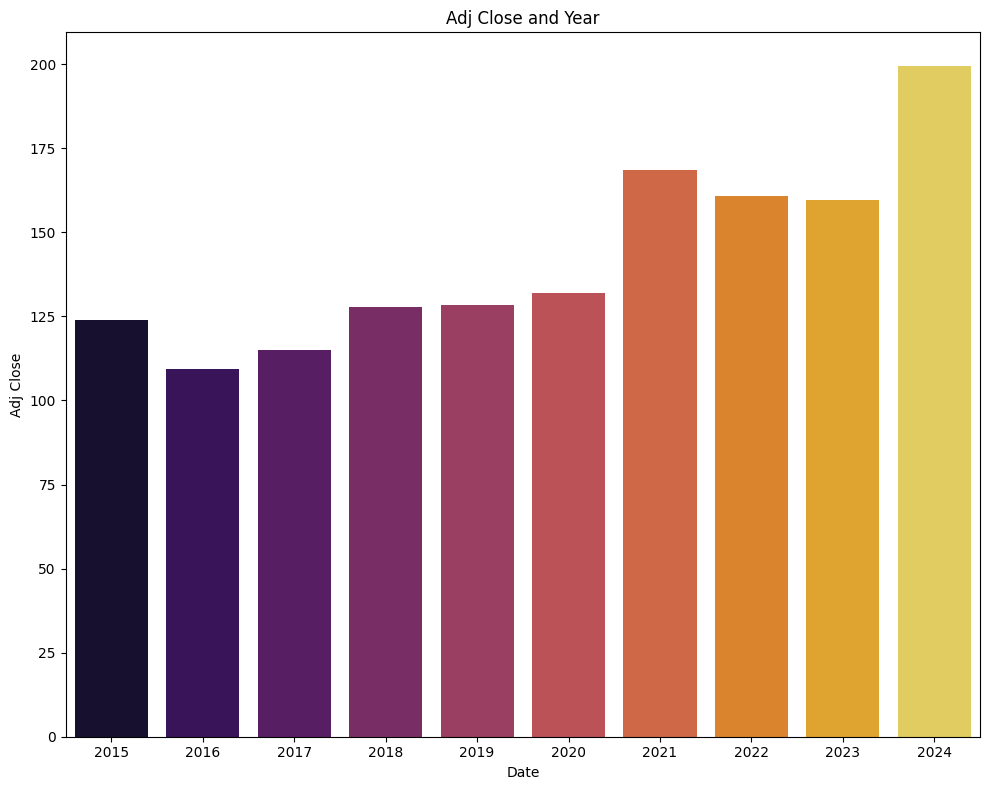

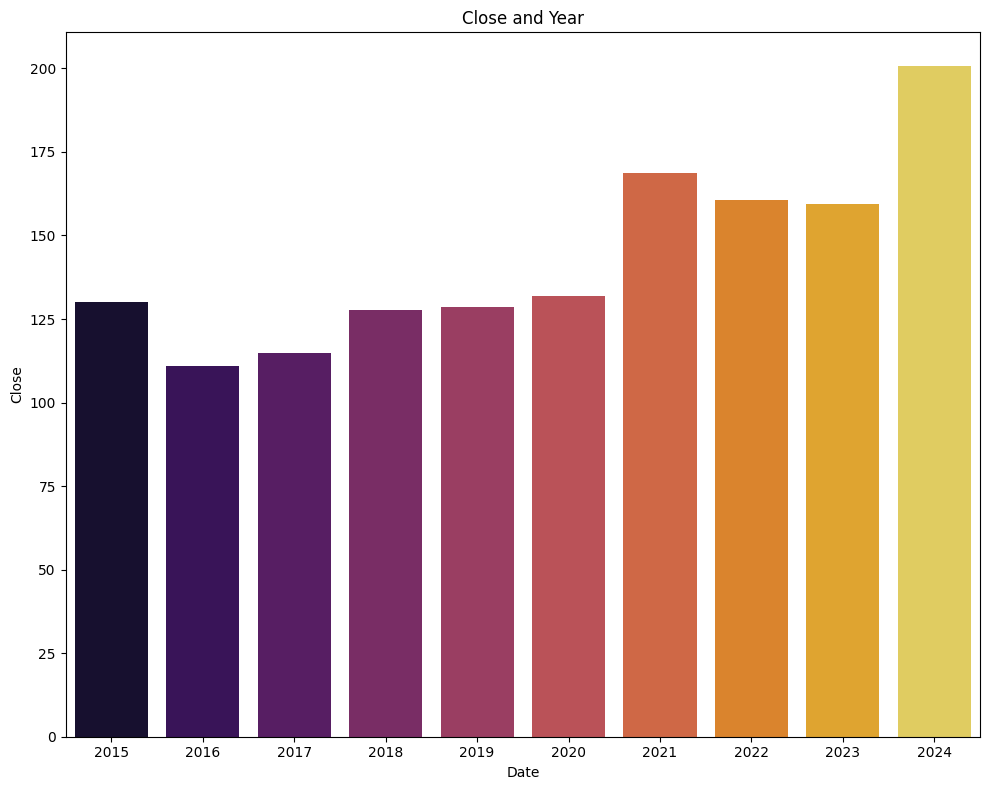

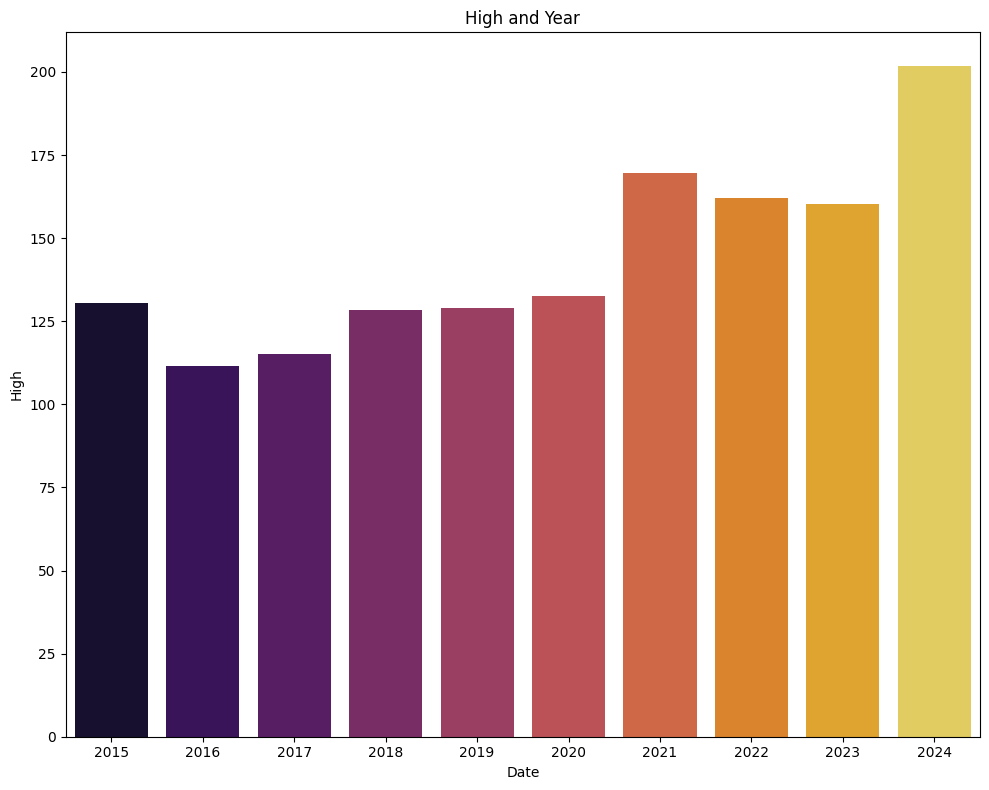

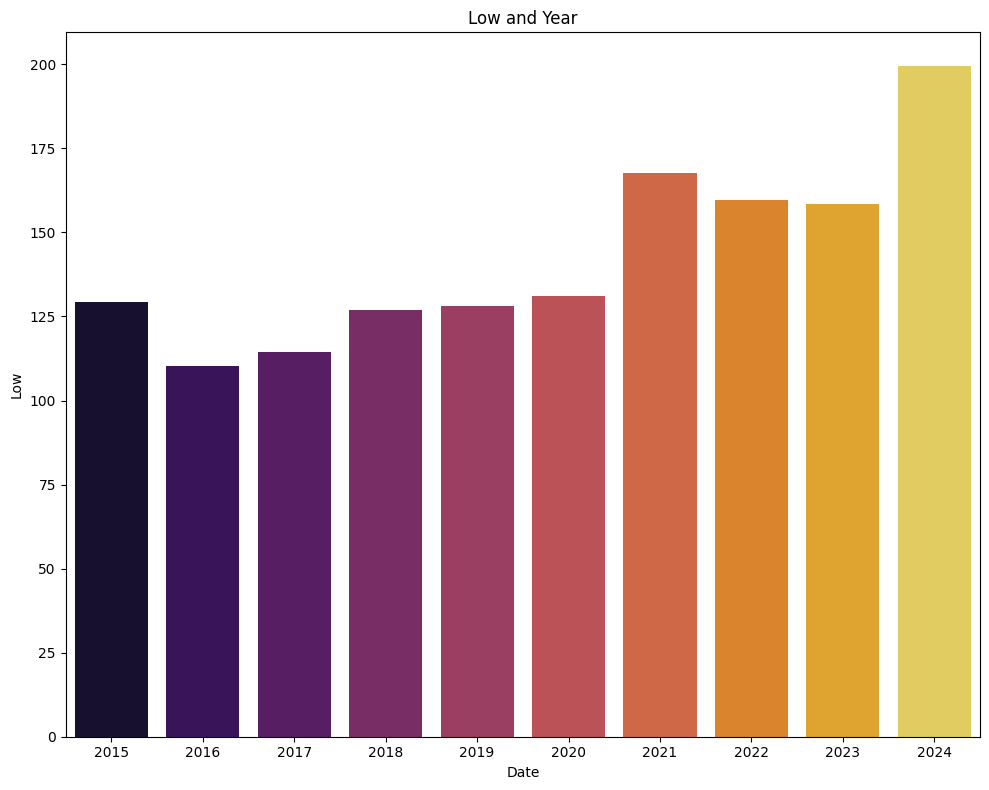

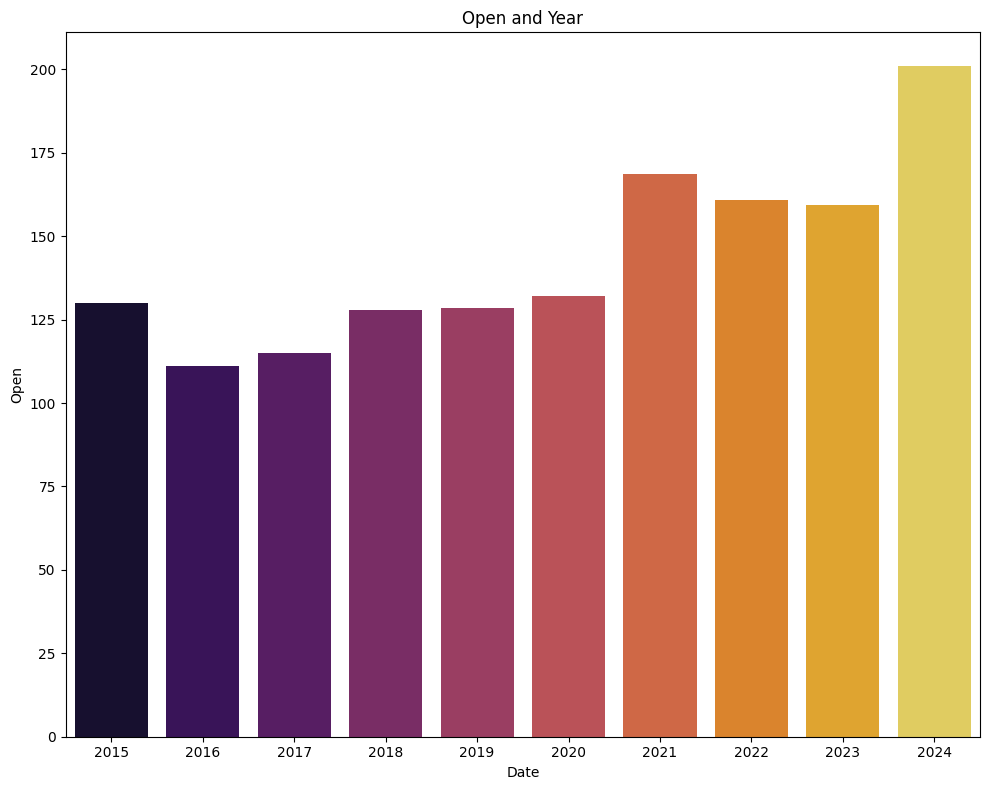

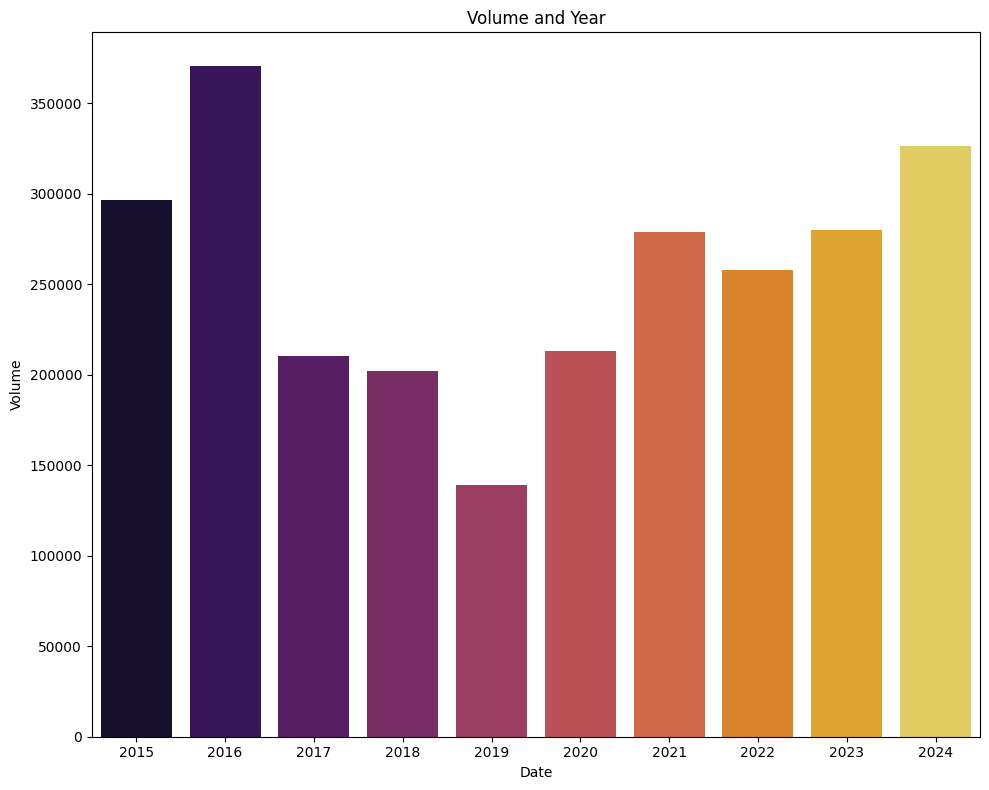

In [22]:
for col in numeric_cols:
    # Tarihi sadece yıl formatına dönüştür
    df["Year"] = pd.to_datetime(df["Date"]).dt.year
    zamana_bağlı_değişim = (
        df.groupby(["Year"], as_index=False)[col]
        .mean()
        .sort_values(by=["Year"], ascending=False)
        .head(10)
    )
    plt.figure(figsize=(10, 8))
    sns.barplot(x="Year", y=col, data=zamana_bağlı_değişim, palette='inferno')
    plt.title(f"{col} and Year")
    plt.xlabel("Date")
    plt.ylabel(f"{col}")
    plt.tight_layout()
    plt.show()


📉**Adj Close**	Bölünme veya temettü gibi şirket eylemlerini hesaba katan düzeltilmiş kapanış fiyatı.

----------------------------------------------------------------

🔒**Close**	Toyota hissesinin ilgili gündeki resmi kapanış fiyatı.

--------------------------------------------------------------
📈**High**	Hisse senedinin işlem seansı sırasında ulaştığı en yüksek fiyat.

------------------------------------------------------------------
📉**Low**Hisse senedinin işlem seansı sırasındaki en düşük fiyatı.

-------------------------------------------------------------------
🔓**Open**	Toyota hissesinin belirtilen gündeki açılış fiyatı.

---------------------------------------------------------------------
🔄**Volume**	Gün içerisinde işlem gören toplam hisse senedi sayısı.

**Yıllara göre Düzeltilmiş Kapanış Fiyatı Ortalamaları**

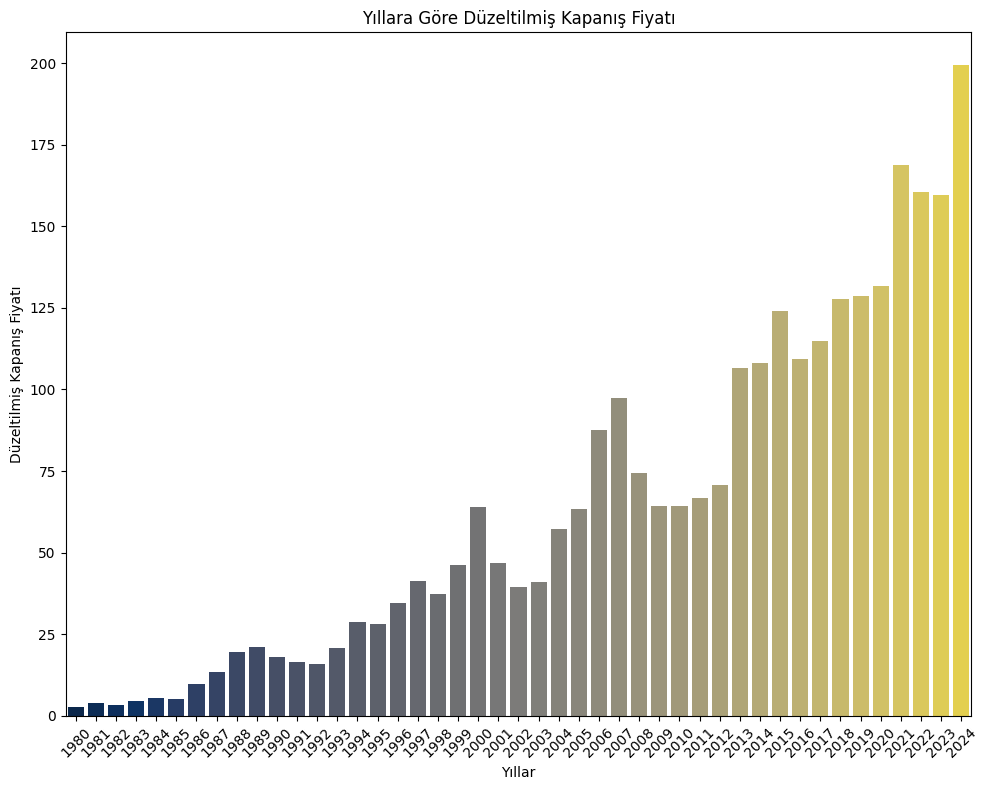

In [23]:
# Yıllara göre Düzeltilmiş Kapanış Fiyatı hesaplama
düzeltilmiş_kapanış = (df.groupby("Year", as_index=False)["Adj Close"].mean().sort_values(by="Adj Close", ascending=False))
plt.figure(figsize=(10, 8))
sns.barplot(x="Year", y="Adj Close", data=düzeltilmiş_kapanış, palette='cividis')
plt.title("Yıllara Göre Düzeltilmiş Kapanış Fiyatı")
plt.xlabel("Yıllar")
plt.xticks(rotation=45)
plt.ylabel("Düzeltilmiş Kapanış Fiyatı")
plt.tight_layout()
plt.show()


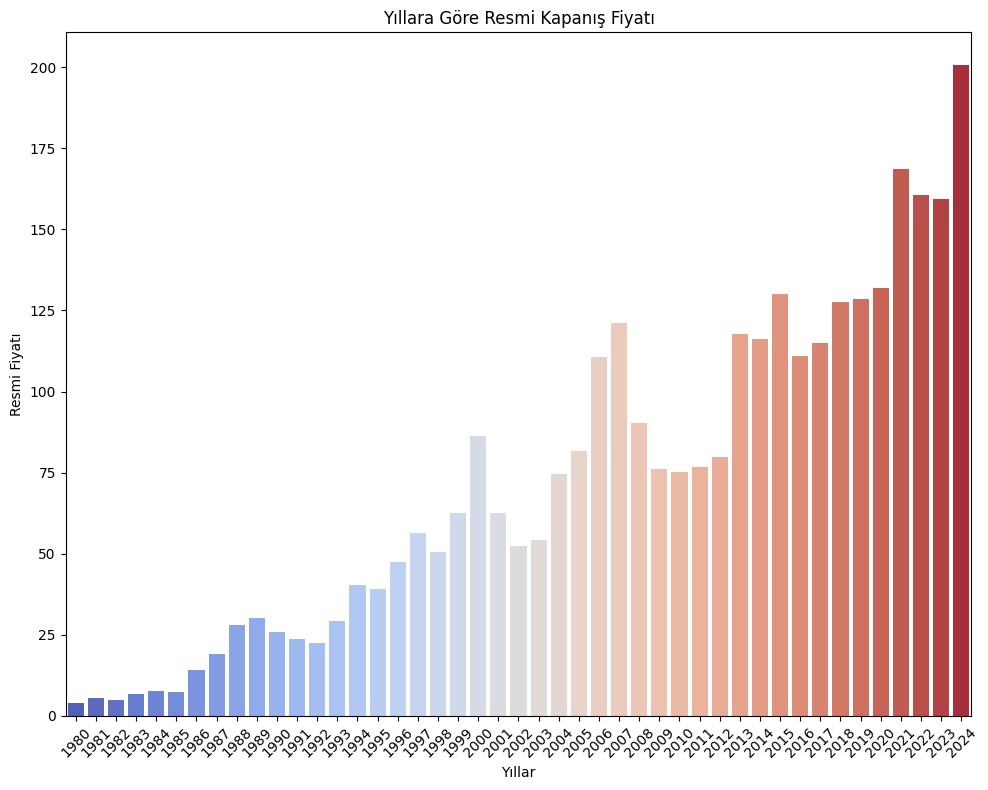

In [24]:
# Yıllara göre Düzeltilmiş Kapanış Fiyatı hesaplama
düzeltilmiş_kapanış = (df.groupby("Year", as_index=False)["Close"].mean().sort_values(by="Close", ascending=False))
plt.figure(figsize=(10, 8))
sns.barplot(x="Year", y="Close", data=düzeltilmiş_kapanış, palette='coolwarm')
plt.title("Yıllara Göre Resmi Kapanış Fiyatı")
plt.xlabel("Yıllar")
plt.xticks(rotation=45)
plt.ylabel("Resmi Fiyatı")
plt.tight_layout()
plt.show()

**İşlem Sırasında En Yüksek Fiyatların Yıllar İçinde Ortalaması**

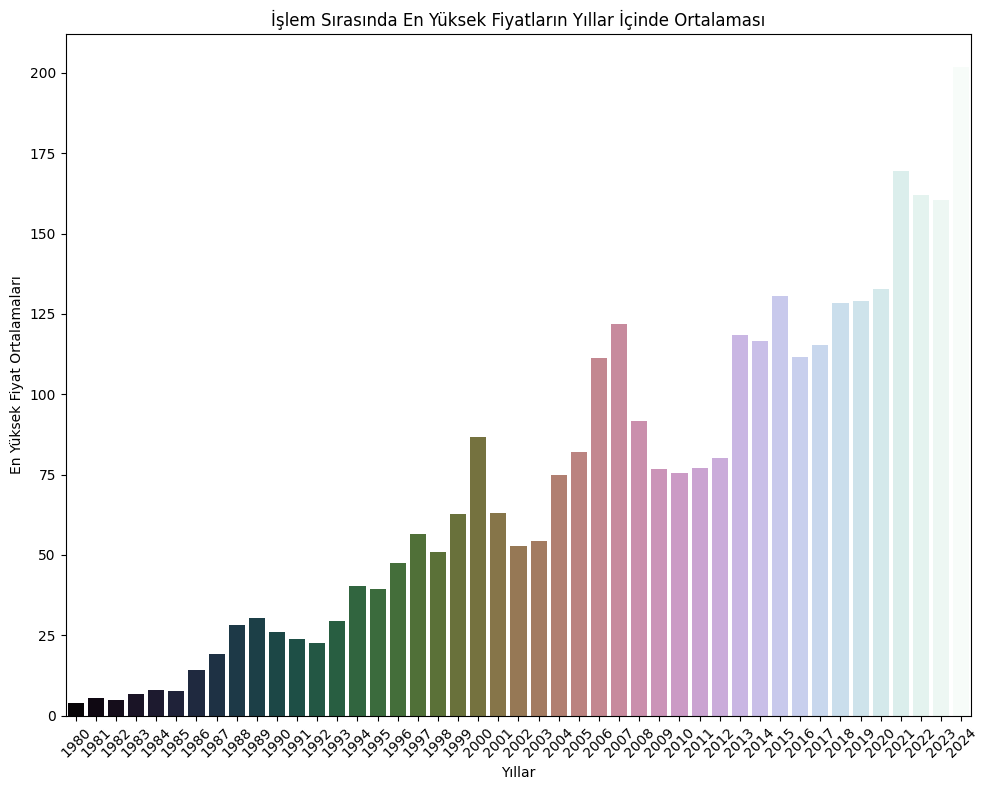

In [25]:
max_fiyat_yıllar=df.groupby('Year',as_index=False)["High"].mean().sort_values(by="High",ascending=False)
plt.figure(figsize=(10,8))
sns.barplot(x='Year',y='High',data=max_fiyat_yıllar,palette='cubehelix')
plt.title("İşlem Sırasında En Yüksek Fiyatların Yıllar İçinde Ortalaması")
plt.ylabel("En Yüksek Fiyat Ortalamaları")
plt.xlabel("Yıllar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**En Düşük İşlem Tutarları Ortalamasının Yıllara Göre Değişimi**

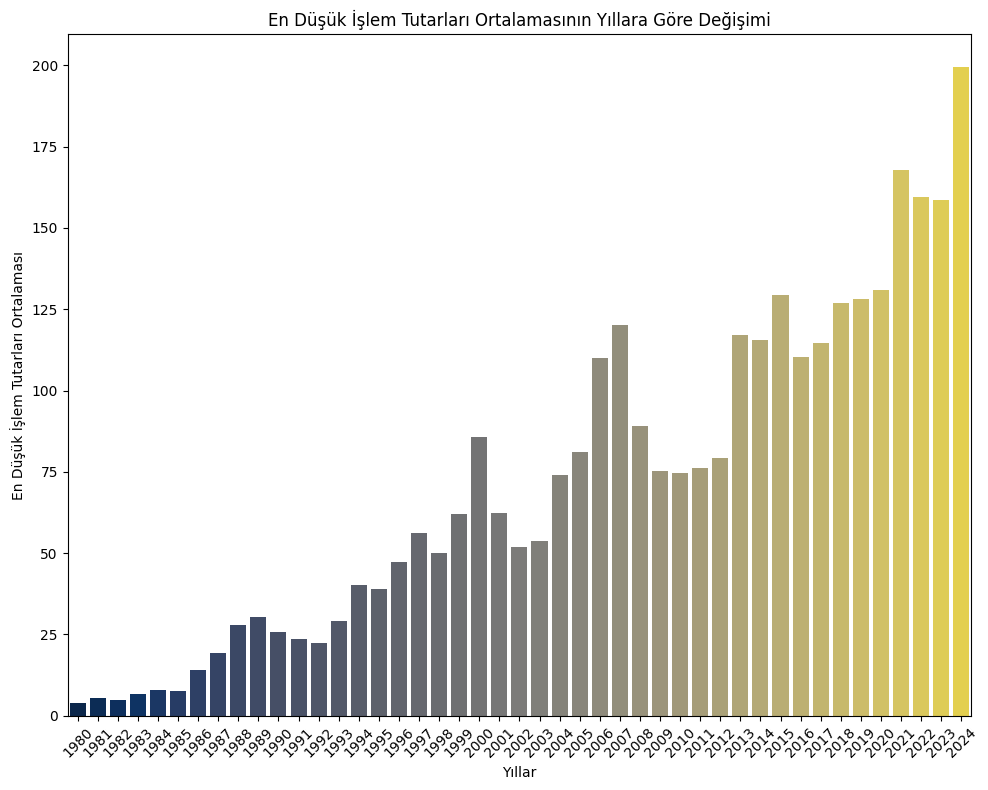

In [26]:
en_düşük_fiyatlara_göre_yıllar=(df.groupby("Year",as_index=False)['Low'].mean().sort_values(by='Low',ascending=False))
plt.figure(figsize=(10,8))
sns.barplot(x="Year",y='Low',data=en_düşük_fiyatlara_göre_yıllar,palette='cividis')
plt.title("En Düşük İşlem Tutarları Ortalamasının Yıllara Göre Değişimi")
plt.xlabel("Yıllar")
plt.ylabel("En Düşük İşlem Tutarları Ortalaması")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Toyota hissesinin belirtilen gündeki açılış fiyatı ortalamalaarının yıllar içerisindeki değişimi**

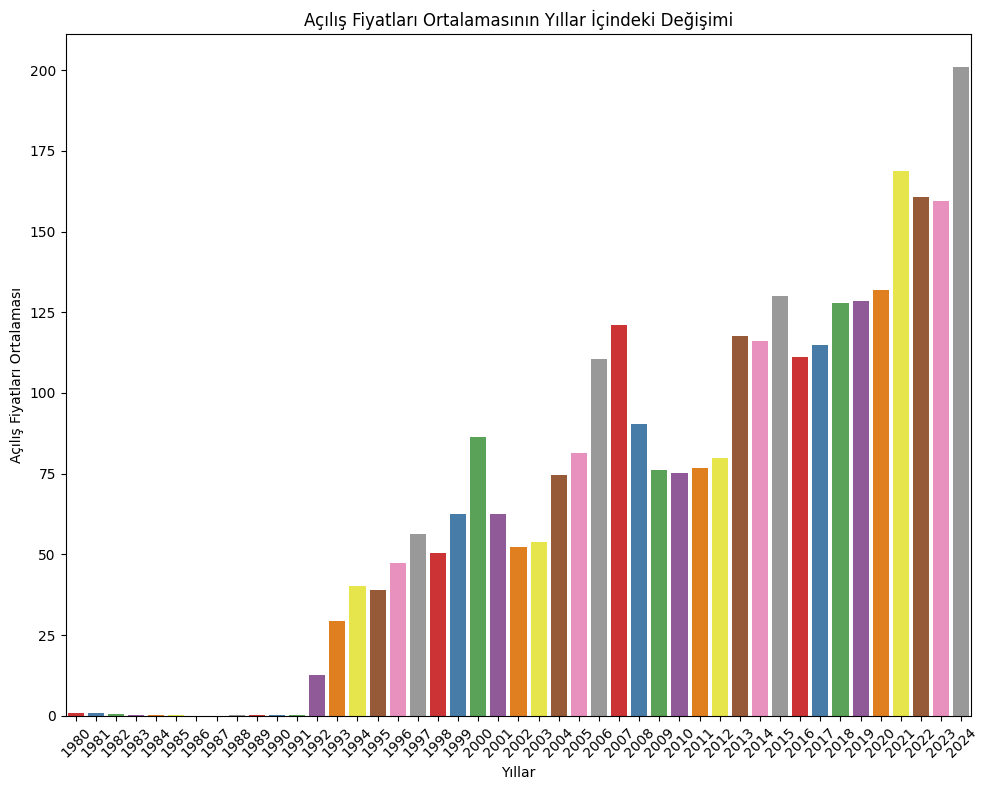

In [27]:
açılış_fiyatı_yıllar=(df.groupby("Year",as_index=False)["Open"].mean().sort_values(by="Open",ascending=False))
plt.figure(figsize=(10,8))
sns.barplot(x="Year",y="Open",data=açılış_fiyatı_yıllar,palette='Set1')
plt.title("Açılış Fiyatları Ortalamasının Yıllar İçindeki Değişimi")
plt.xticks(rotation=45)
plt.xlabel("Yıllar")
plt.ylabel("Açılış Fiyatları Ortalaması")
plt.tight_layout()
plt.show()

**Gün İçerisinde İşlem Gören Toplam Hisse Senedi Sayısı Ortalaması**

In [28]:
numeric_cols

['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

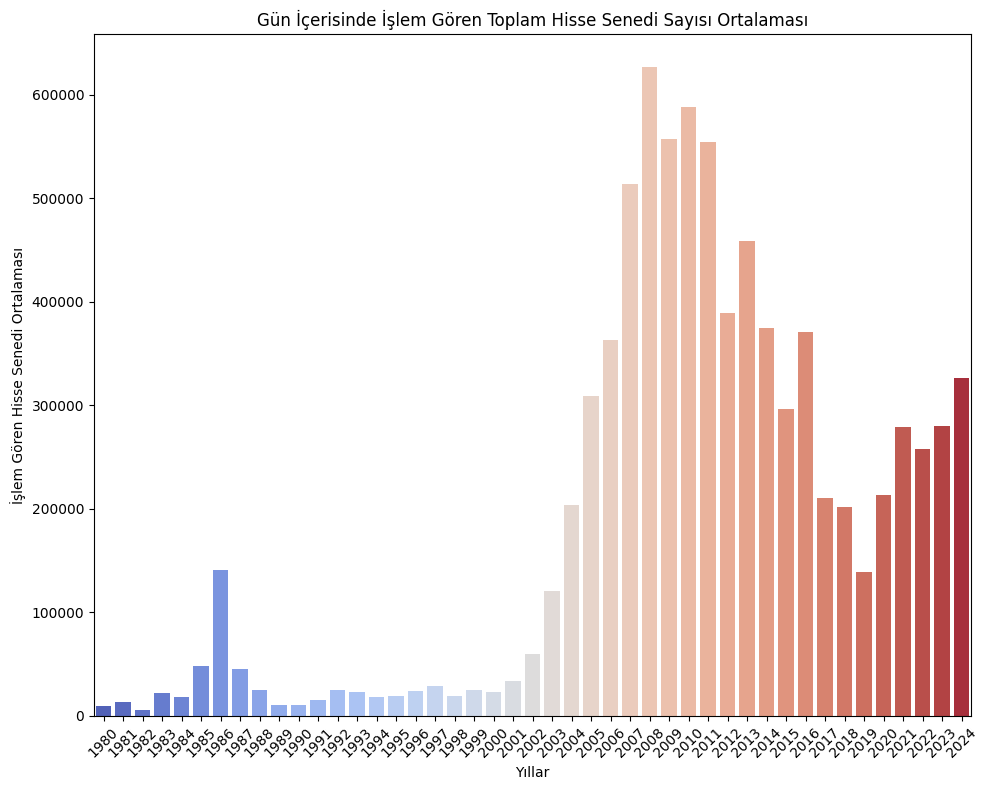

In [29]:
hisse_senedi_sayısı_yıllar=(df.groupby("Year",as_index=False)['Volume'].mean().sort_values(by='Volume',ascending=False))
plt.figure(figsize=(10,8))
sns.barplot(x="Year",y="Volume",data=hisse_senedi_sayısı_yıllar,palette='coolwarm')
plt.title("Gün İçerisinde İşlem Gören Toplam Hisse Senedi Sayısı Ortalaması")
plt.xticks(rotation=45)
plt.xlabel("Yıllar")
plt.ylabel("İşlem Gören Hisse Senedi Ortalaması")
plt.tight_layout()
plt.show()

📉**Adj Close**	Bölünme veya temettü gibi şirket eylemlerini hesaba katan düzeltilmiş kapanış fiyatı.

----------------------------------------------------------------

🔒**Close**	Toyota hissesinin ilgili gündeki resmi kapanış fiyatı.

--------------------------------------------------------------
📈**High**	Hisse senedinin işlem seansı sırasında ulaştığı en yüksek fiyat.

------------------------------------------------------------------
📉**Low**Hisse senedinin işlem seansı sırasındaki en düşük fiyatı.

-------------------------------------------------------------------
🔓**Open**	Toyota hissesinin belirtilen gündeki açılış fiyatı.

---------------------------------------------------------------------
🔄**Volume**	Gün içerisinde işlem gören toplam hisse senedi sayısı.

In [30]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Year
0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109,1980
1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343,1980
2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0,1980
3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277,1980
4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409,1980


In [31]:
toyota_df = df[["Date","Close"]]

In [32]:
print("Minimum Date : ",toyota_df["Date"].min())
print("Maximum Date : ",toyota_df["Date"].max())

Minimum Date :  1980-03-17 00:00:00
Maximum Date :  2024-12-27 00:00:00


In [33]:
toyota_df.index = toyota_df["Date"]

In [34]:
toyota_df.drop("Date",axis=1,inplace=True)

In [35]:
toyota_df.head()

,Close
Date,
1980-03-17,3.291227
1980-03-18,3.304606
1980-03-19,3.304606
1980-03-20,3.304606
1980-03-21,3.384880


In [36]:
result_df = toyota_df.copy()

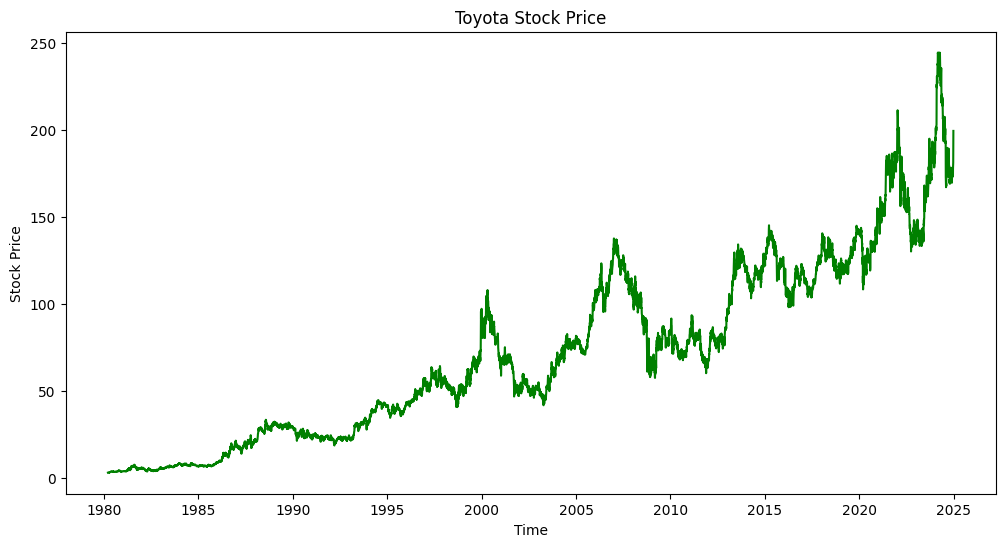

In [37]:
plt.figure(figsize=(12,6))
plt.plot(toyota_df["Close"],color="g")
plt.title('Toyota Stock Price')
plt.ylabel("Stock Price")
plt.xlabel("Time")
plt.show()

In [38]:
toyota_df = toyota_df.values

In [39]:
toyota_df[0:5]

array([[3.2912271 ],
       [3.30460596],
       [3.30460596],
       [3.30460596],
       [3.38488007]])

In [40]:
toyota_df = toyota_df.astype('float32')

In [41]:
def split_data(data,test_size):
    pos = int(round(len(data)*(1-test_size)))
    train = data[:pos]
    test = data[pos:]
    return train , test , pos

In [42]:
train , test , pos = split_data(toyota_df,0.20)

In [43]:
print(train.shape , test.shape)

(9033, 1) (2258, 1)


In [44]:
scaler_train = MinMaxScaler(feature_range=(0,1))
scaler_test = MinMaxScaler(feature_range=(0,1))

In [45]:
train = scaler_train.fit_transform(train)
test = scaler_test.fit_transform(test)

In [46]:
train[0:5]

array([[0.00037666],
       [0.00047082],
       [0.00047082],
       [0.00047082],
       [0.0010358 ]], dtype=float32)

In [47]:
test[0:5]

array([[0.10120076],
       [0.11317515],
       [0.1201545 ],
       [0.11440676],
       [0.12330204]], dtype=float32)

In [48]:
def create_features(data,lb):
    X,Y = [],[]
    for i in range(lb,len(data)):
        X.append(data[i-lb:i,0])
        Y.append(data[i,0])

    return np.array(X),np.array(Y)

In [49]:
lb = 25

In [50]:
X_train , Y_train = create_features(train,lb)
X_test , Y_test = create_features(test,lb)

In [51]:
print(f"X Train Shape : {X_train.shape}\nY Train Shape : {Y_train.shape}\nX Test Shape : {X_test.shape}\nY Test Shape : {Y_test.shape}")

X Train Shape : (9008, 25)
Y Train Shape : (9008,)
X Test Shape : (2233, 25)
Y Test Shape : (2233,)


In [52]:
X_train = np.reshape(X_train , (X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test , (X_test.shape[0],1,X_test.shape[1]))

Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)

In [53]:
print(f"X Train Shape : {X_train.shape}\nY Train Shape : {Y_train.shape}\nX Test Shape : {X_test.shape}\nY Test Shape : {Y_test.shape}")

X Train Shape : (9008, 1, 25)
Y Train Shape : (9008, 1)
X Test Shape : (2233, 1, 25)
Y Test Shape : (2233, 1)


In [54]:
model = Sequential()
model.add(LSTM(units=100,
         activation='relu',
         input_shape=(X_train.shape[1],lb)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [55]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          50,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,501 (197.27 KB)

 Trainable params: 50,501 (197.27 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [57]:
callbacks = [EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode='min'),
            ModelCheckpoint(filepath='mymodel.keras',monitor='val_loss',mode='min',
                           save_best_only=True,save_weights_only=False,verbose=1)]

In [58]:
history = model.fit(x=X_train,
                   y=Y_train,
                   epochs=100,
                   batch_size=32,
                   validation_data=(X_test,Y_test),
                   callbacks = callbacks,
                   shuffle=False)

Epoch 1/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5156e-04
Epoch 1: val_loss improved from inf to 0.00627, saving model to mymodel.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.5634e-04 - val_loss: 0.0063
Epoch 2/100
272/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 2: val_loss improved from 0.00627 to 0.00425, saving model to mymodel.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 3/100
272/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 3: val_loss improved from 0.00425 to 0.00409, saving model to mymodel.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 4/100
275/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 4: val_loss did not improve from 0.00409
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013 - val_loss: 0.0136
Epoch 5/100
265/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 5: val_loss did not improve from 0.00409
282/282 ━━━━━━━━

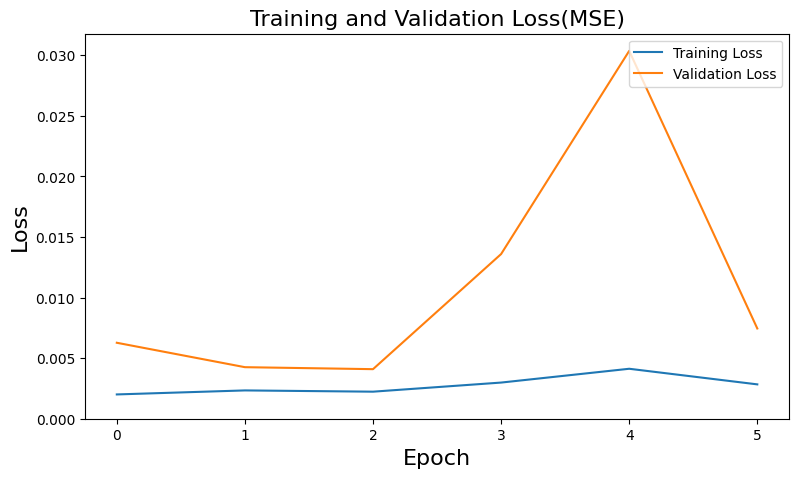

In [59]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label='Training Loss')
plt.plot(history.history["val_loss"],label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss(MSE)',fontsize=16)
plt.show()

In [60]:
loss=model.evaluate(X_test,Y_test,batch_size=32)
print("Test Loss(MSE) : %.2f%%"% (100*loss))

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Test Loss(MSE) : 0.74%
